In [ ]:
#share the model (same training model for ALL contributors): first train on all data then call predict for each by_types

In [17]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from numpy import concatenate
from matplotlib import pyplot
from sklearn import preprocessing

In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
def train_model(by_types):
    # load dataset
    timeSteps = 1
    dataset = by_types
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 3)

    
    # splitting the data
    # training on only first 70% data
    features = by_types.shape[1]
    train_hours = int(0.7*len(values))
    X = np.asarray(reframed)[:,:(features*timeSteps)]
    y = np.asarray(reframed)[:,features*timeSteps]

    train_X = X[:train_hours,:]
    test_X = X[train_hours:,:]
    train_y = y[:train_hours]
    test_y = y[train_hours:]

    #convert data to fit for lstm
    #dimensions = (sample, timeSteps here it is 1, features )

    train_X = train_X.reshape(train_X.shape[0], timeSteps, features)
    test_X = test_X.reshape(test_X.shape[0], timeSteps, features)
    
    embed_dim = 128
    # design network
    model = Sequential()
    #model.add(Embedding(2000, embed_dim,input_length = X.shape[1], dropout = 0.2))
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=30, batch_size=2000, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    return model
    
def predict_vals(model):
    # load dataset
    timeSteps = 1
    dataset = by_types
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 3)
    #print("reframed")
    #print(reframed)

    
    # splitting the data
    # training on only first 70% data
    #display(by_types)
    features = by_types.shape[1]
    #print("features: " + str(features))
    train_hours = int(0.7*len(values))
    X = np.asarray(reframed)[:,:(features*timeSteps)]
    #print("X")
    #print(X)
    y = np.asarray(reframed)[:,features*timeSteps]
    #print("Y")
    #print(y)

    train_X = X[:train_hours,:]
    test_X = X[train_hours:,:]
    train_y = y[:train_hours]
    test_y = y[train_hours:]
    #print(train_X)
    #print(test_X)
    #print(train_y)
    #print(test_y)

    #convert data to fit for lstm
    #dimensions = (sample, timeSteps here it is 1, features )

    train_X = train_X.reshape(train_X.shape[0], timeSteps, features)
    test_X = test_X.reshape(test_X.shape[0], timeSteps, features)
    #scale back the prediction to orginal scale
    y_pred = model.predict(test_X)
    test_X = test_X.reshape(test_X.shape[0],test_X.shape[2]*test_X.shape[1])

    inv_new = np.concatenate( (y_pred, test_X[:,-2:] ) , axis =1)
    inv_new = scaler.inverse_transform(inv_new)
    final_pred = inv_new[:,0]
    #print(inv_new)

    test_y = test_y.reshape( len(test_y), 1)

    inv_new = np.concatenate( (test_y, test_X[:,-2:] ) ,axis = 1)
    inv_new = scaler.inverse_transform(inv_new)
    actual_pred = inv_new[:,0]
    #print(final_pred)
    #print(actual_pred)
    #plot the prediction with actual data
    
    aa=[x for x in range(200)]
    plt.figure(figsize = (20, 20))
    plt.plot(aa,final_pred[:200], marker = '.', label = "prediction",c = "b")
    plt.plot(aa,by_types[:200]['price'], marker = '.', label = "actual data",c="r")
    plt.title("comparison between prediction and actual data")
    plt.legend()
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 233003 samples, validate on 99856 samples
Epoch 1/30
 - 4s - loss: 0.3107 - val_loss: 0.2906
Epoch 2/30
 - 2s - loss: 0.2596 - val_loss: 0.2887
Epoch 3/30
 - 3s - loss: 0.2589 - val_loss: 0.2880
Epoch 4/30
 - 2s - loss: 0.2588 - val_loss: 0.2878
Epoch 5/30
 - 2s - loss: 0.2589 - val_loss: 0.2879
Epoch 6/30
 - 2s - loss: 0.2587 - val_loss: 0.2878
Epoch 7/30
 - 2s - loss: 0.2586 - val_loss: 0.2878
Epoch 8/30
 - 3s - loss: 0.2586 - val_loss: 0.2879
Epoch 9/30
 - 3s - loss: 0.2586 - val_loss: 0.2879
Epoch 10/30
 - 3s - loss: 0.2586 - val_loss: 0.2878
Epoch 11/30
 - 2s - loss: 0.2584 - val_loss: 0.2877
Epoch 12/30
 - 2s - loss: 0.2584 - val_loss: 0.2879
Epoch 13/30
 - 2s - loss: 0.2584 - val_loss: 0.2877
Epoch 14/30
 - 2s - loss: 0.2583 - val_loss: 0.2877
Epoch 15/30
 - 2s - loss: 0.2583 - val_loss: 0.2875
Epoch 16/30
 - 2s - loss: 0.2583 - val_loss: 0.2876
Epoch 17/30
 - 2s - loss: 0.2583 - val_loss: 0.2877
Epoch 18/30
 - 2s - loss: 0.2582 - val_loss: 0.2876
Epoch 19/30
 - 3s - lo

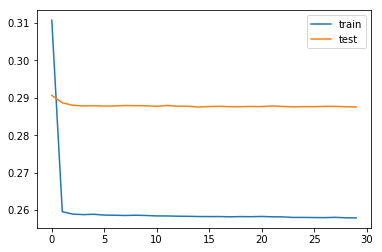

by_types after timeElapsed


,price,srcid,timeElapsed
date,,,
2019-06-25 02:13:59,2.0771,0,0.0
2019-06-25 02:14:10,2.0770,0,11.0
2019-06-25 02:14:18,2.0772,0,8.0
2019-06-25 02:25:26,2.0792,0,668.0
2019-06-25 02:25:28,2.0794,0,2.0
2019-06-25 02:25:30,2.0793,0,2.0
2019-06-25 02:25:38,2.0798,0,8.0
2019-06-25 02:25:40,2.0797,0,2.0
2019-06-25 02:26:26,2.0798,0,46.0


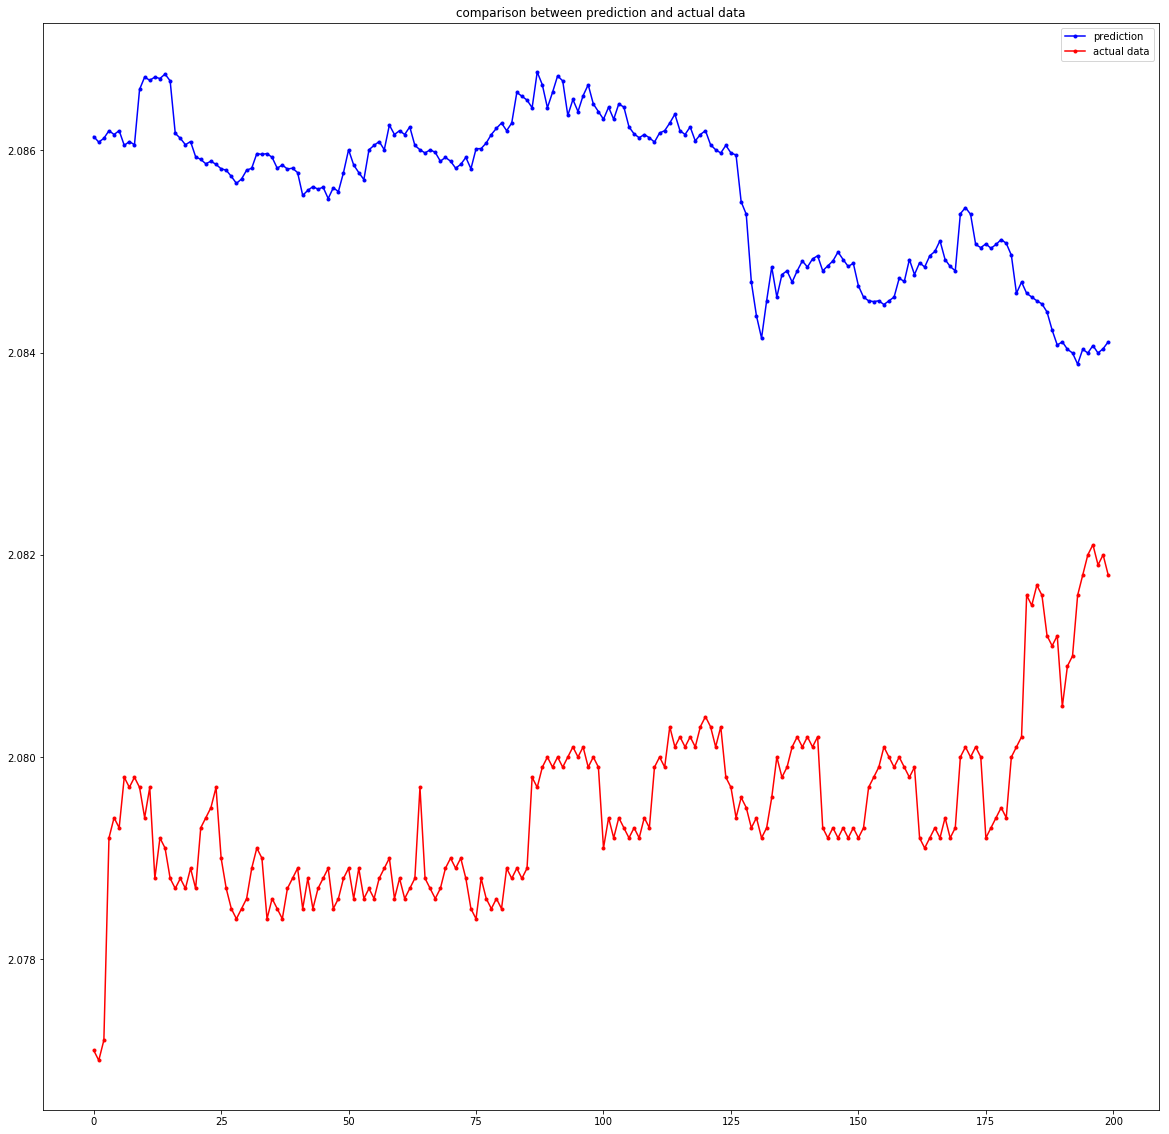

by_types after timeElapsed


,price,srcid,timeElapsed
date,,,
2019-06-25 12:56:59,2.0743,1,0.0
2019-06-25 12:57:01,2.0744,1,2.0
2019-06-25 12:57:02,2.0742,1,1.0
2019-06-25 12:57:12,2.0741,1,10.0
2019-06-25 12:57:14,2.0743,1,2.0
2019-06-25 12:57:15,2.0744,1,1.0
2019-06-25 12:57:18,2.0745,1,3.0
2019-06-25 12:57:19,2.0746,1,1.0
2019-06-25 12:57:24,2.0745,1,5.0


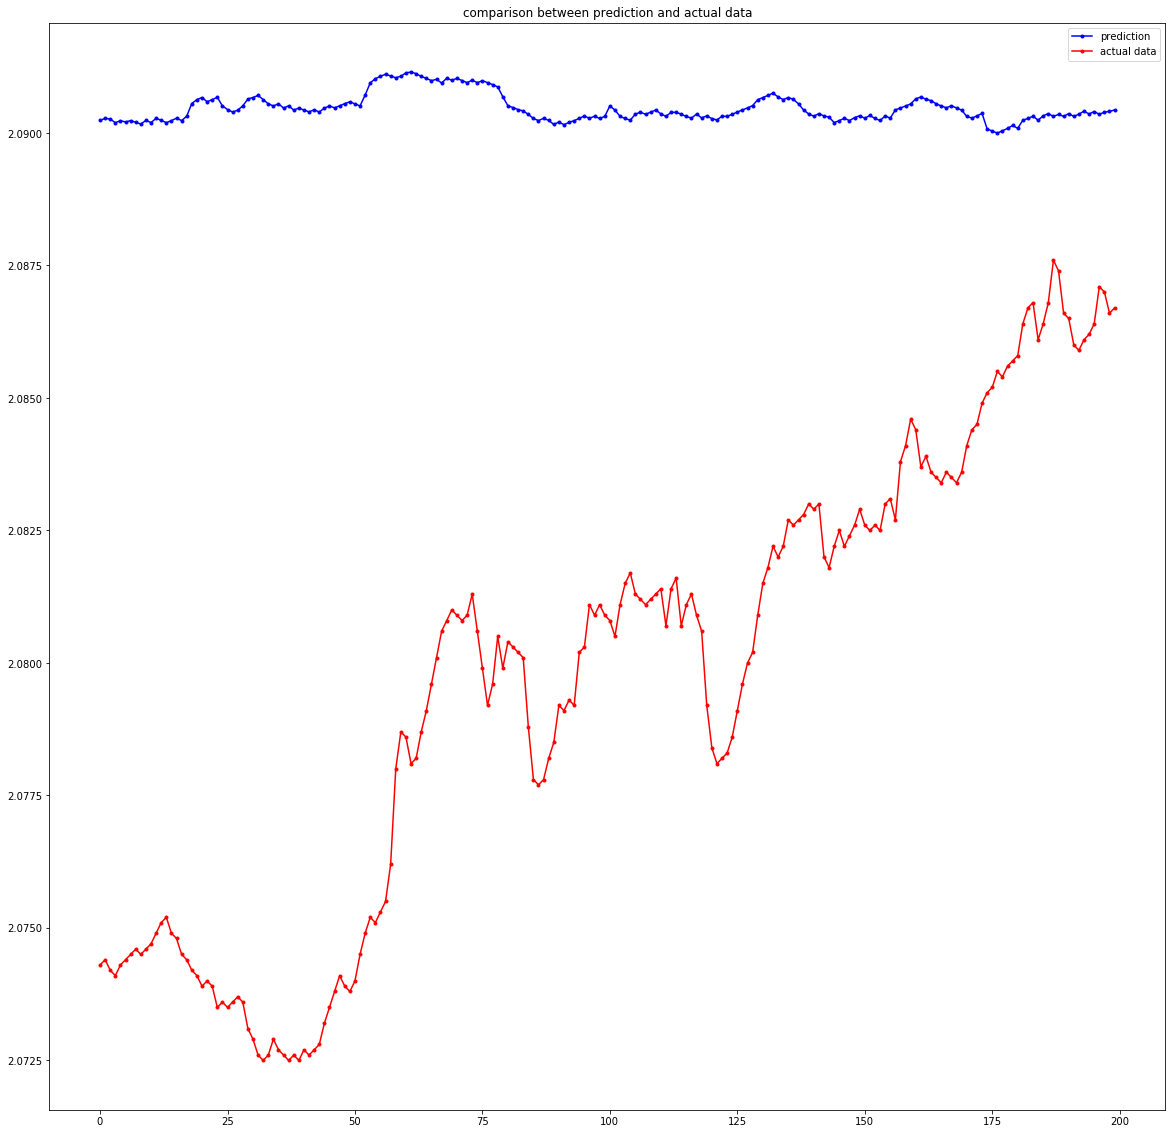

by_types after timeElapsed


,price,srcid,timeElapsed
date,,,
2019-06-24 20:02:13,2.0955,2,0.0
2019-06-24 20:02:15,2.0950,2,2.0
2019-06-24 20:02:17,2.0950,2,2.0
2019-06-24 20:02:23,2.0955,2,6.0
2019-06-24 20:02:55,2.0950,2,32.0
2019-06-24 20:03:01,2.0945,2,6.0
2019-06-24 20:03:07,2.0960,2,6.0
2019-06-24 20:03:07,2.0955,2,0.0
2019-06-24 20:03:10,2.0955,2,3.0


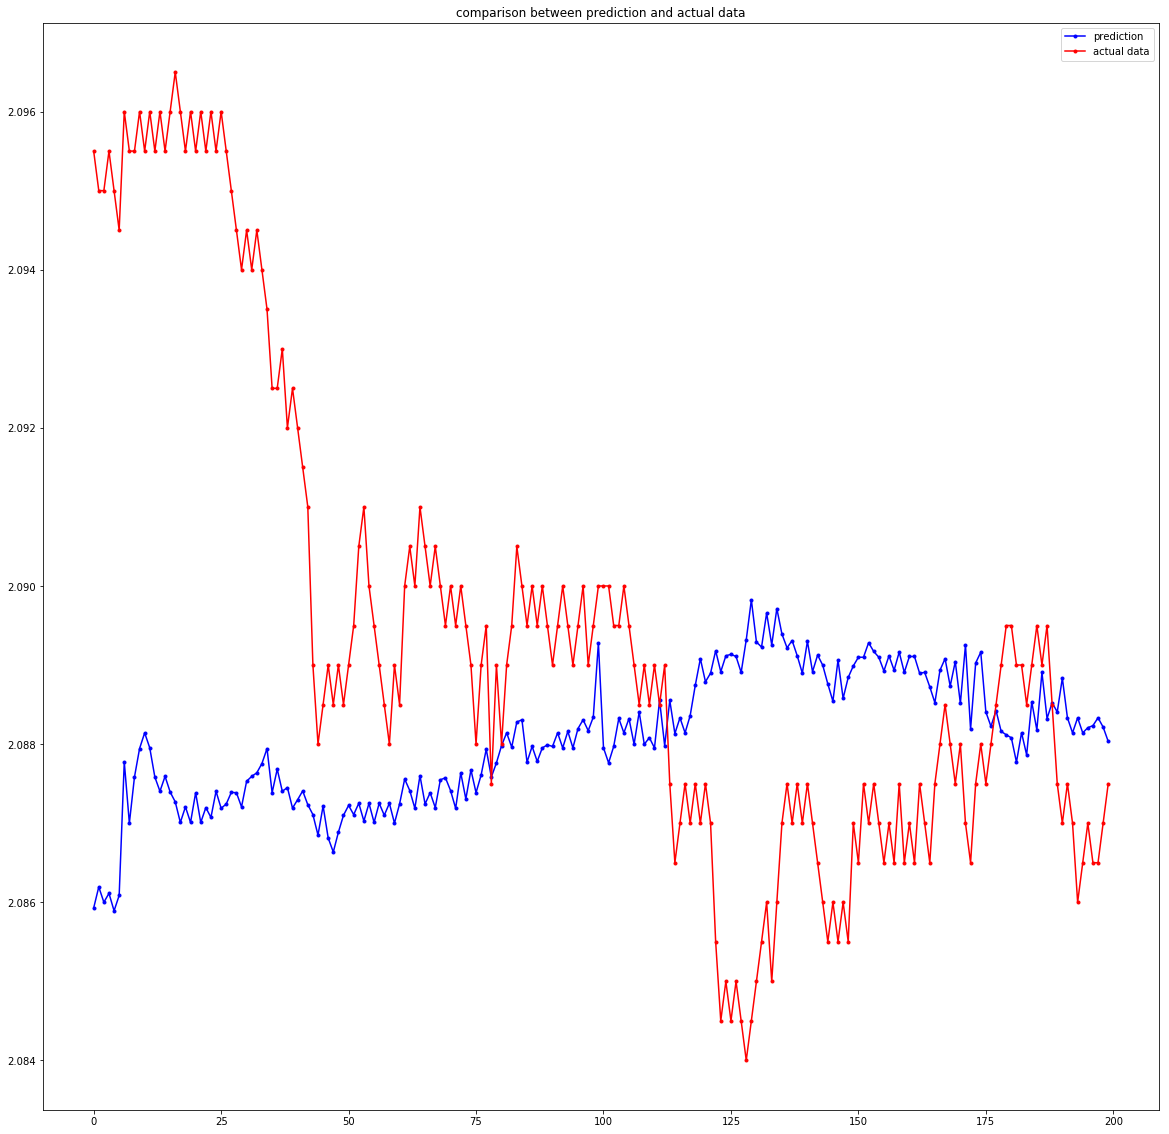

by_types after timeElapsed


,price,srcid,timeElapsed
date,,,
2019-06-24 19:36:55,2.0934,3,0.0
2019-06-24 19:37:05,2.0934,3,10.0
2019-06-24 19:37:24,2.0939,3,19.0
2019-06-24 19:37:25,2.0934,3,1.0
2019-06-24 19:38:25,2.0941,3,60.0
2019-06-24 19:38:26,2.0936,3,1.0
2019-06-24 19:38:37,2.0941,3,11.0
2019-06-24 19:38:38,2.0942,3,1.0
2019-06-24 19:38:38,2.0940,3,0.0


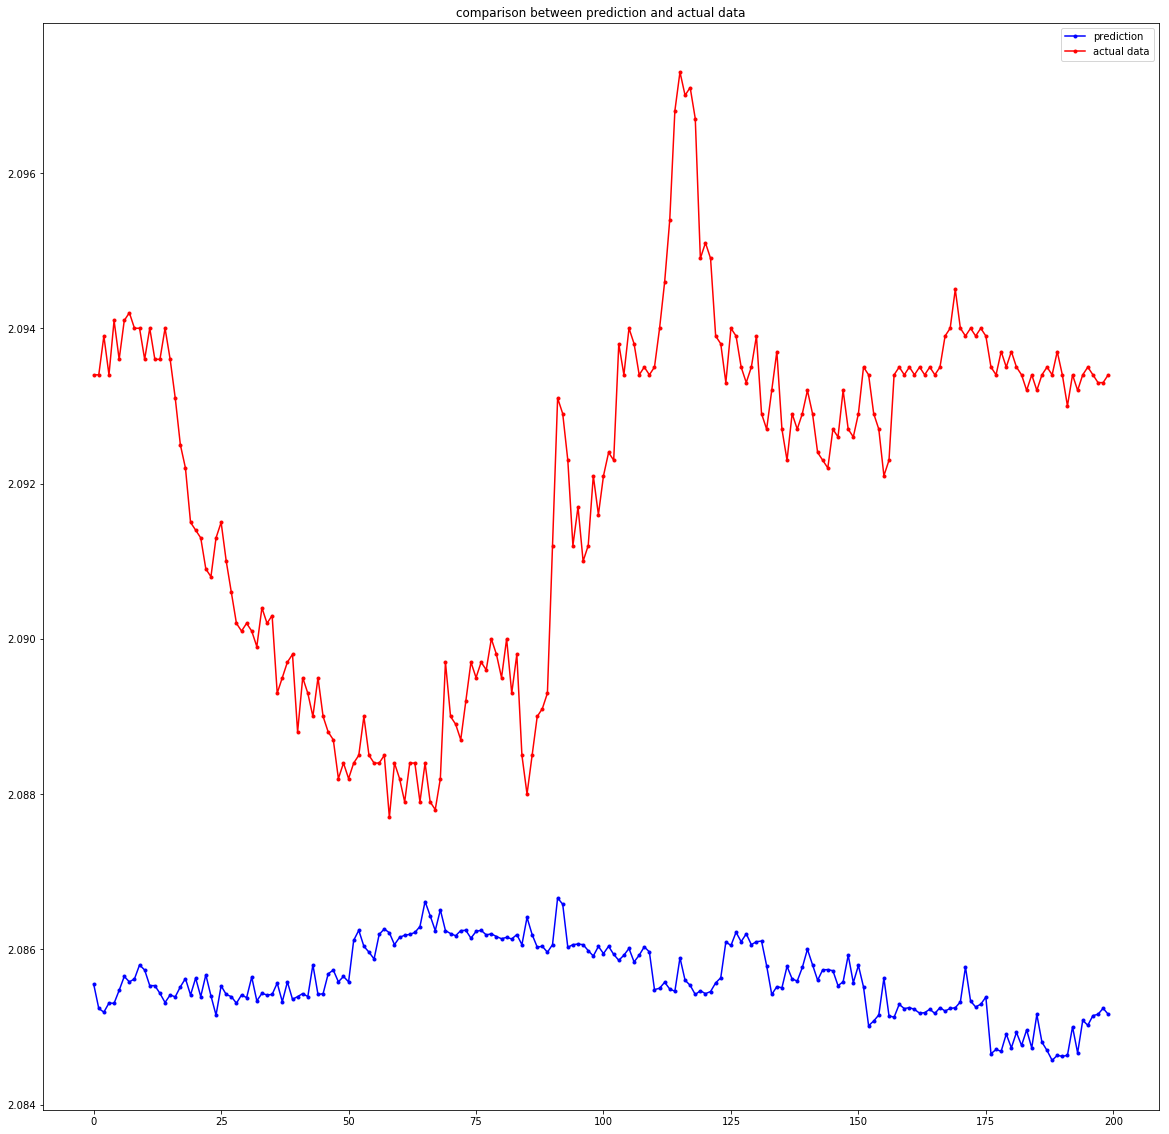

by_types after timeElapsed


,price,srcid,timeElapsed
date,,,
2019-06-24 20:14:06,2.0893,4,0.0
2019-06-24 20:14:29,2.0885,4,23.0
2019-06-24 20:14:29,2.0890,4,0.0
2019-06-24 20:14:33,2.0868,4,4.0
2019-06-24 20:14:42,2.0860,4,9.0
2019-06-24 20:14:45,2.0862,4,3.0
2019-06-24 20:14:47,2.0865,4,2.0
2019-06-24 20:14:47,2.0864,4,0.0
2019-06-24 20:14:49,2.0862,4,2.0


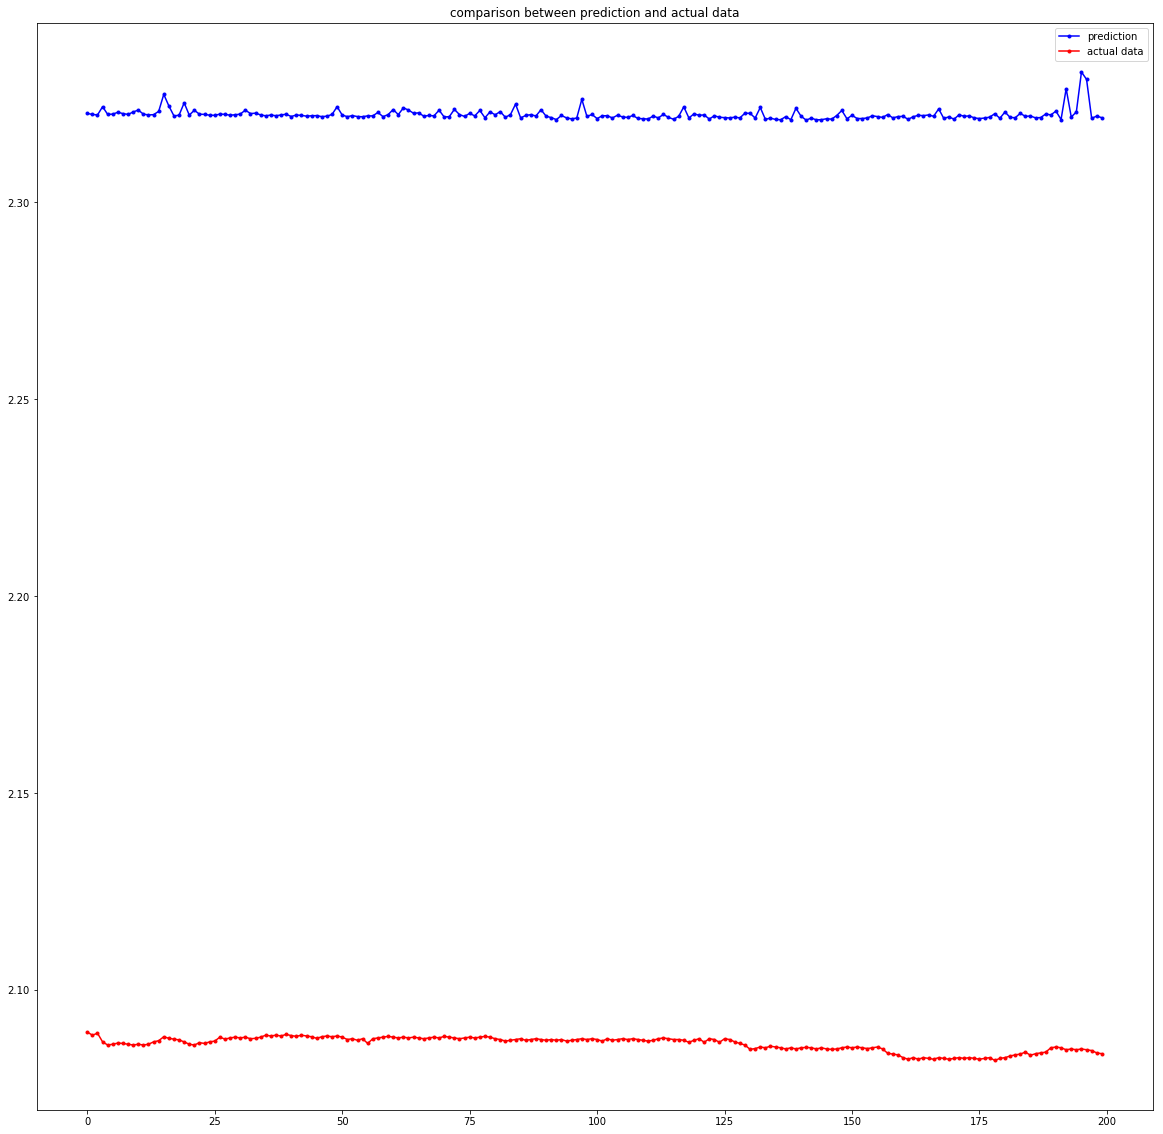

by_types after timeElapsed


,price,srcid,timeElapsed
date,,,
2019-06-25 00:42:41,2.0675,5,0.0
2019-06-25 00:43:50,2.0675,5,69.0
2019-06-25 00:43:54,2.0690,5,4.0
2019-06-25 00:43:58,2.0705,5,4.0
2019-06-25 00:44:10,2.0700,5,12.0
2019-06-25 00:44:14,2.0690,5,4.0
2019-06-25 00:44:17,2.0700,5,3.0
2019-06-25 00:45:19,2.0700,5,62.0
2019-06-25 00:45:23,2.0695,5,4.0


In [ ]:
with open('/tmp/USSWAP15-sorted.dat', 'r') as file: 
    data = [] 
    next(file) 
    for i in range(1000000): 
        line = file.readline() 
        info = line.rstrip().split(',')
        if float(info[-1]) != 0:
            data.append(info) 
        columnLabels = "tickerid|0|srcid|ts|date|flags|flags|type|price"
    #create DataFrame
    df = pd.DataFrame(data = np.array(data), columns = columnLabels.split('|'))

    dates = df['date']
    split_dates = []

    for elem in dates:
        split_dates.append(elem.replace('_',' '))
    df['date'] = split_dates
    df['date'] = df.date.astype('datetime64[ns]')
    df['price'] = df.price.astype('float')
    df = df.drop(columns = ['0', 'ts', 'flags'])
    df = df.set_index('date')
    
        
        
    
    df = df.reset_index()
    df = df.set_index('srcid')
    df = df.sort_values(by = ['date'])
    time_elapsed = []
    lastTime = -9999
    types = df.groupby('type')
    for y in types.groups:
        lastTime = -9999
        time_elapsed = []
        by_types = types.get_group(y)
        #add column for time differences

        for i in range(len(by_types)):
            currentTime = by_types.iloc[i]['date']
            if lastTime == -9999:
                time_elapsed.append(0)
            else:
                time_elapsed.append((currentTime-lastTime).total_seconds())
            lastTime = currentTime
        by_types['timeElapsed'] = time_elapsed
        by_types = by_types.reset_index()
        by_types = by_types.set_index('date')
        #sources = by_types['srcid']
        
        
        #label encoding and splitting data
        le = preprocessing.LabelEncoder()
        #le.fit(sources)
        #sources = le.transform(le.classes_)
        by_types['srcid'] = le.fit_transform(by_types['srcid'])
        #print(by_types['srcid'])
        #print(len(by_types['srcid']))
        #print(len(sources))
        #by_types['srcid'] = sources
        
        
        #by_types = by_types.drop(columns = ['tickerid', 'srcid', 'type'])
        types = by_types['type']
        by_types = by_types.drop(columns = ['tickerid', 'type'])
        #display(by_types)
        model = train_model(by_types)
        #by_types['srcid'] = sources
        
        by_types['type'] = types
        contributors = by_types.groupby('srcid')
        #by_types = by_types.reindex(columns = ['srcid', 'price'])
    
        for x in contributors.groups:
            by_contrib = contributors.get_group(x)
            types = by_contrib.groupby('type')
            #print("by_contrib in contrib groups loop")
            #display(by_contrib)
            for y in types.groups:
                lastTime = -9999
                time_elapsed = []
                by_types = types.get_group(y)
                #print("by_types in contrib group loop")
                #display(by_types)
                #add column for time differences

                for i in range(len(by_types)):
                    #currentTime = by_types.iloc[i]['date']
                    currentTime = by_types.reset_index().loc[i, 'date']
                    if lastTime == -9999:
                        time_elapsed.append(0)
                    else:
                        time_elapsed.append((currentTime-lastTime).total_seconds())
                    lastTime = currentTime
                    
                by_types['timeElapsed'] = time_elapsed
                by_types = by_types.reset_index()
                by_types = by_types.set_index('date')
                #by_types = by_types.drop(columns = ['tickerid', 'type'])
                by_types = by_types.drop(columns = ['type'])
                #by_types = by_types.reindex(columns = ['srcid', 'price'])
                cols = ['price', 'srcid', 'timeElapsed']
                by_types = by_types[cols]
                print("by_types after timeElapsed")
                display(by_types)
                
                #predict_vals(train_X, test_X, train_y, test_y, model)
                predict_vals(model)

In [ ]:
#Problems: not graphing correct values
#need to separate by types before training because otherwise the time elapsed will be inaccurate
#relatively large error between train and test
#Observations:
#validation set IS the test set; adding Dropout layer made the error larger

#try: separate and then loop through everything and train, then loop through all dfs again and predict + graph


In [ ]:
#Rescaled data from -1 to 1
